In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector as connection
import os
import seaborn as sns

# Suppressing matplotlib and pandas warings
import warnings
warnings.filterwarnings("ignore")


Connecting to database

In [123]:
from dotenv import load_dotenv

# Loading data from .env used for connecting to database
load_dotenv()

connector = connection.connect(
    user=os.getenv("DB_USER"),
    database=os.getenv("DB_NAME"),
    host=os.getenv("DB_HOST"),
    password=os.getenv("DB_PASSWORD")
    )

Data base model

<img title="a title" alt="Alt text" src="mysql-sample-database.png">

List of countries

In [124]:
countries = pd.read_sql(
    """
    SELECT DISTINCT country
    FROM customers
    ORDER BY country
    """, connector)
countries

,country
0,Australia
1,Austria
2,Belgium
3,Canada
4,Denmark
5,Finland
6,France
7,Germany
8,Hong Kong
9,Ireland


Best selling countries

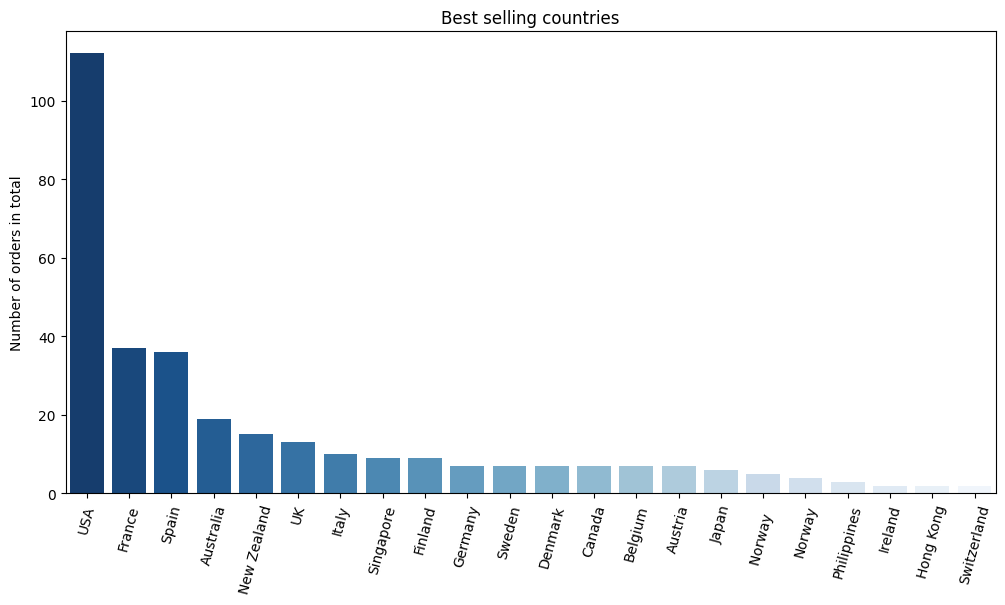

In [125]:
bestSellingCountries = pd.read_sql(
    """
    SELECT
        customers.country,
        COUNT(orders.orderNumber) AS totalOrders
    FROM customers
    INNER JOIN orders 
    ON customers.customerNumber = orders.customerNumber
    GROUP BY customers.country
    ORDER BY totalOrders DESC
    """, connector)

# Visualization of best selling countries
plt.figure(figsize=(12,6))
sns.barplot(x=bestSellingCountries["country"],y=bestSellingCountries["totalOrders"],palette='Blues_r')
plt.title("Best selling countries")
plt.xlabel(None)
plt.ylabel("Number of orders in total")
plt.xticks(rotation=75)
plt.show()

Best selling products

In [126]:
bestSellingProducts = pd.read_sql(
    """
    SELECT 
        products.productName,
        products.productScale,
        products.productLine,
        orderdetails.priceEach,
        SUM(orderdetails.quantityOrdered) AS totalQuantity
    FROM products
    INNER JOIN orderDetails 
    ON products.productCode = orderdetails.productCode
    INNER JOIN orders
    ON orderdetails.orderNumber = orders.orderNumber
    GROUP BY
		products.productName,
        products.productScale,
        products.productLine,
        orderdetails.priceEach
    ORDER BY totalQuantity DESC;
    """, connector)

bestSellingProducts["totalQuantity"] = bestSellingProducts["totalQuantity"].astype(int)
# Calculare revenue column
bestSellingProducts["revenue"] = bestSellingProducts["priceEach"] * bestSellingProducts["totalQuantity"]

bestSellingProducts.head(n=10)

,productName,productScale,productLine,priceEach,totalQuantity,revenue
0,1960 BSA Gold Star DBD34,1:24,Motorcycles,61.70,245,15116.50
1,ATA: B757-300,1:700,Planes,98.48,237,23339.76
2,1936 Chrysler Airflow,1:24,Vintage Cars,95.44,203,19374.32
3,1982 Ducati 900 Monster,1:24,Motorcycles,56.10,203,11388.30
4,1969 Corvair Monza,1:18,Classic Cars,145.04,200,29008.00
5,1957 Corvette Convertible,1:18,Classic Cars,120.53,198,23864.94
6,Corsair F4U ( Bird Cage),1:24,Planes,55.96,197,11024.12
7,1917 Grand Touring Sedan,1:18,Vintage Cars,153.00,195,29835.00
8,1930 Buick Marquette Phaeton,1:50,Vintage Cars,35.78,194,6941.32
9,1966 Shelby Cobra 427 S/C,1:24,Classic Cars,43.27,190,8221.30


Total revenue and units sold

In [204]:
totalRevenue = bestSellingProducts["revenue"].sum()
totalUnitsSold = bestSellingProducts["totalQuantity"].sum()
numberOfCustomers = pd.read_sql(
    """
    SELECT customerNumber
    FROM customers
    """, connector)

print(f"Total Units Sold: {totalUnitsSold}")
print(f"Total Revenue: {totalRevenue} USD")
print(f"Total customers: {numberOfCustomers.shape[0]}")


Total Units Sold: 105516
Total Revenue: 9604190.61 USD
Total customers: 122


Average customer

Average order value for individual customer: 29049.30 USD


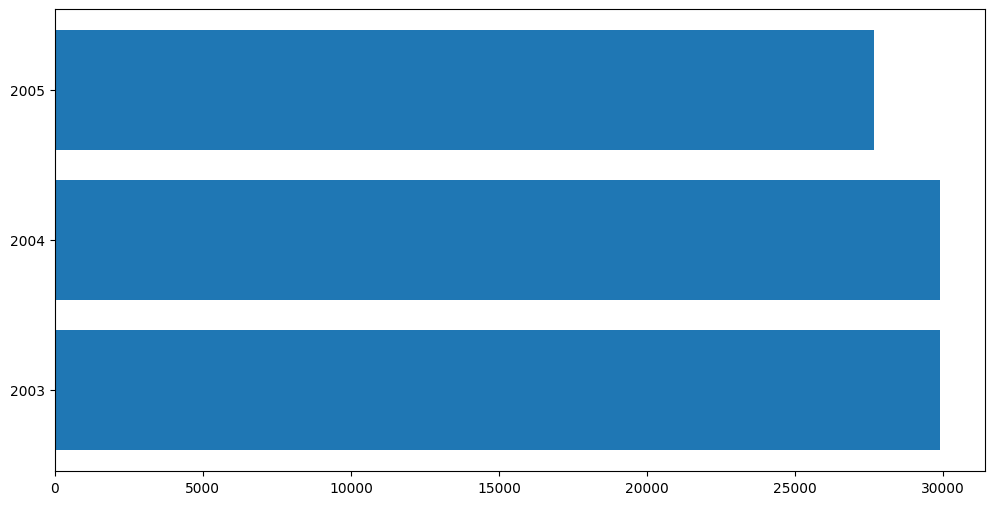

In [203]:
averageOfCustomers = pd.read_sql(
    """
    SELECT 
        AVG(customerAvgOrders.averageOrderPrice) AS averageOrderPriceAcrossAllCustomers
    FROM (
        SELECT 
            orders.customerNumber,
            AVG(orderTotals.totalPrice) AS averageOrderPrice
        FROM 
            orders
        INNER JOIN (
            SELECT 
                orderdetails.orderNumber,
                SUM(orderdetails.quantityOrdered * orderdetails.priceEach) AS totalPrice
            FROM 
                orderdetails
            GROUP BY 
                orderdetails.orderNumber
        ) AS orderTotals
        ON 
            orders.orderNumber = orderTotals.orderNumber
        GROUP BY 
            orders.customerNumber
    ) AS customerAvgOrders
    """, connector)

averageOfCustomersForGivenYear = pd.read_sql(
    """
    SELECT
        YEAR(orders.orderDate) AS orderYear,
        AVG(orderTotals.totalPrice) AS averageOrder
    FROM orders
    INNER JOIN (
        SELECT
            orderdetails.orderNumber,
            SUM(orderdetails.quantityOrdered * orderdetails.priceEach) AS totalPrice
        FROM orderdetails
        GROUP BY orderNumber
    ) AS orderTotals
    ON orders.orderNumber = orderTotals.orderNumber
    GROUP BY orderYear
    ORDER BY orderYear
    """, connector)

firstYear = averageOfCustomersForGivenYear["orderYear"].iloc[0]
lastYear = averageOfCustomersForGivenYear["orderYear"].iloc[len(averageOfCustomersForGivenYear) - 1]

plt.figure(figsize=(12, 6))
plt.barh(y=averageOfCustomersForGivenYear["orderYear"],
         width=averageOfCustomersForGivenYear["averageOrder"])
plt.yticks(np.arange(firstYear, lastYear + 1,step=1))
print(f"Average order value for individual customer: {averageOfCustomers.iloc[0, 0]:.2f} USD")


Time series for orders

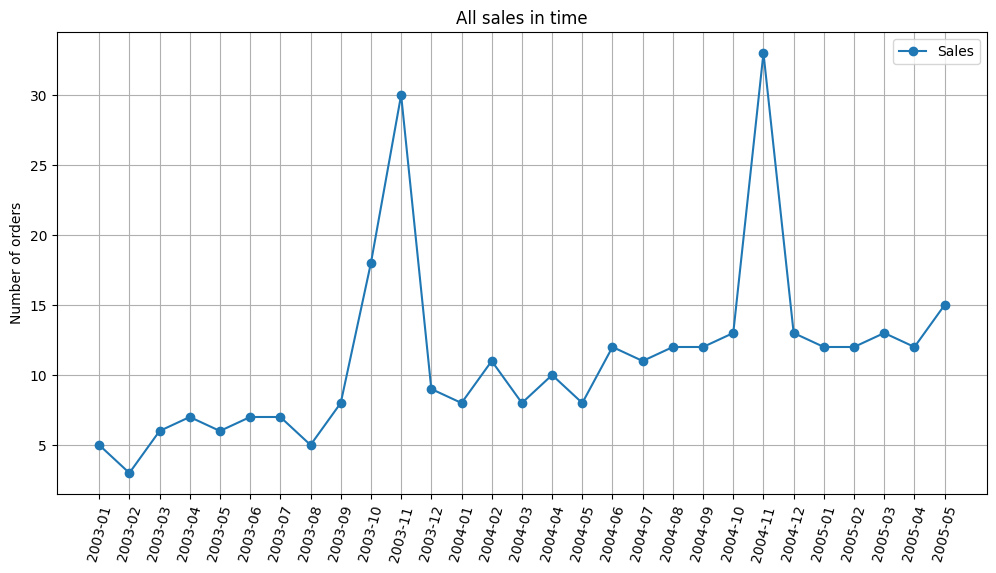

In [161]:
# We get date in format Year - Month
salesInTime = pd.read_sql(
    """
    SELECT 
        COUNT(orderNumber) AS orderCount,
        DATE_FORMAT(orderDate, '%Y-%m') AS date
    FROM orders
    GROUP BY date
    ORDER BY date
    """, connector)

# Visualization of sales in time
plt.figure(figsize=(12,6))
plt.plot(salesInTime["date"], salesInTime["orderCount"], marker='o',label="Sales")
plt.title("All sales in time")
plt.xlabel(None)
plt.ylabel("Number of orders")
plt.xticks(rotation=75)
plt.legend()
plt.grid(True)
plt.show()

Compare years for orders

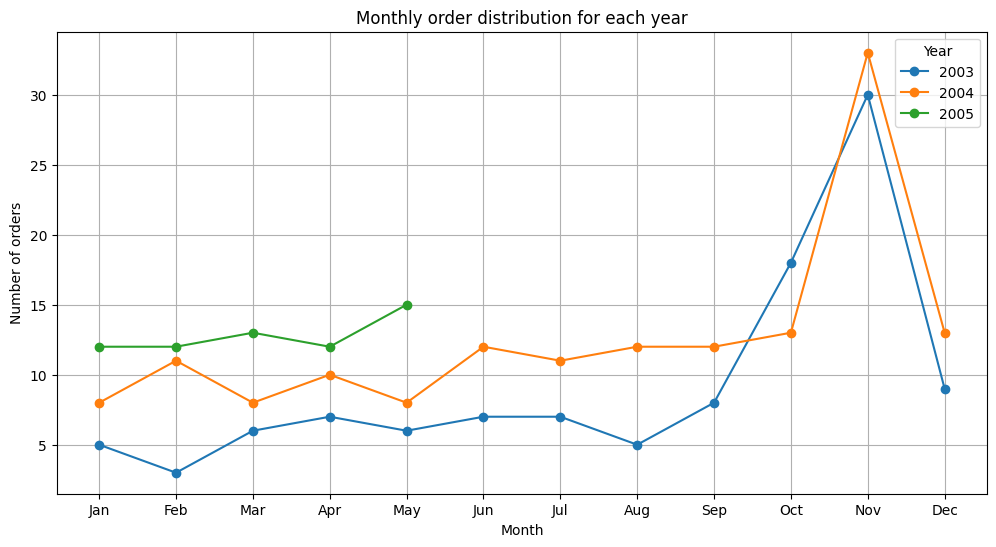

In [162]:
salesInTime['date'] = pd.to_datetime(salesInTime['date'], format='%Y-%m')   # Reformat date
# Divide date column into year and month columns
salesInTime['year'] = salesInTime['date'].dt.year
salesInTime['month'] = salesInTime['date'].dt.month
salesInTimeByYears = salesInTime.pivot(index='month', columns='year', values='orderCount')

# Visualization of monthly order distribution for each year
plt.figure(figsize=(12, 6))
for year in salesInTimeByYears.columns:
    plt.plot(salesInTimeByYears.index, salesInTimeByYears[year], marker='o', label=year)
plt.title('Monthly order distribution for each year')
plt.xlabel('Month')
plt.ylabel('Number of orders')
plt.xticks(ticks=range(1, 13), labels=[
           'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True)
plt.show()